
# EDA · Saber 11 (2018) — Nariño y Pasto · **TFM Data Science**

Este cuaderno desarrolla un **Análisis Exploratorio de Datos (EDA)** profesional sobre la cohorte **Saber 11 – 2016**, con foco en **Nariño** (y corte específico **Pasto**).  
El EDA está **alineado a los objetivos del TFM**: construir una base confiable de entrada para estimar, más adelante, el **Valor Agregado (VA)** y la **Contribución Relativa (CR)** del programa **Ingeniería de Sistemas – Universidad Mariana** al comparar **Saber 11 (entrada)** vs **Saber Pro (salida)**.

### Qué persigue este EDA
- **Calidad de datos**: unificar 2018_1 + 2018_2, limpiar tipos, normalizar textos, validar rangos y duplicados.
- **Caracterización de entrada** (baseline): puntajes globales y por áreas en Nariño / Pasto.
- **Contexto sociodemográfico**: género, estrato, naturaleza del colegio y jornada.
- **Estructuras agregadas** listas para VA/CR**: resúmenes por colegio y municipio exportados como insumo para el modelado.
- **Gráficas explicativas**: cada figura responde a una pregunta de negocio del TFM (ver notas bajo cada gráfico).

> **Nota**: Este cuaderno **no** calcula VA ni CR. Deja listos los **features** de entrada (Saber 11) que luego se cruzarán con **Saber Pro** por cohorte.


In [2]:

import os
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.grid": True
})

print("Libs OK")

Libs OK



## 1) Lectura y unión de fuentes

Archivos oficiales ICFES (TXT `;`) de **2018**: primer y segundo semestre.  
**Edite las rutas si cambian los nombres.**


In [3]:

FILE_2016_1 = "Examen_Saber_11_20181.txt"
FILE_2016_2 = "Examen_Saber_11_20182.txt"

# Columnas de interés (tolerante: si falta alguna, el lector no falla)
COLS = [
    # Ubicación y colegio
    "cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion",
    "cole_depto_ubicacion","cole_mcpio_ubicacion",
    "cole_nombre_establecimiento","cole_naturaleza","cole_area_ubicacion","cole_jornada","cole_genero",
    # Estudiante / familia
    "estu_genero","estu_inse_individual","fami_estratovivienda",
    # Puntajes
    "punt_global","punt_matematicas","punt_lectura_critica",
    "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles",
    # Meta
    "periodo"
]

def safe_read(path, cols):
    if not os.path.exists(path):
        print(f"⚠️ No se encontró: {path}")
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(path, sep=";", encoding="latin1", low_memory=False)
    keep = [c for c in cols if c in df.columns]
    return df[keep].copy()

df1 = safe_read(FILE_2016_1, COLS)
df2 = safe_read(FILE_2016_2, COLS)
df = pd.concat([df1, df2], ignore_index=True)
print("Dimensiones combinadas:", df.shape)
df.head(3)

Dimensiones combinadas: (674990, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
0,76.0,76111.0,VALLE,GUADALAJARA DE BUGA,COLEGIO COMFANDI BUGA,NO OFICIAL,URBANO,MAÃANA,MIXTO,F,55.858322,Estrato 3,158,29,40,36,32,0.0,20181
1,11.0,11001.0,BOGOTA,BOGOTÃ D.C.,GIMNASIO CAMPESTRE DE GUILFORD,NO OFICIAL,RURAL,COMPLETA,MIXTO,M,61.794701,Estrato 5,363,71,74,74,69,81.0,20181
2,17.0,17513.0,CALDAS,PÃCORA,INSTITUCION EDUCATIVA MARCO FIDEL SUAREZ,OFICIAL,URBANO,COMPLETA,MIXTO,M,NaN,Estrato 2,195,50,33,33,39,42.0,20181



## 2) Limpieza / Normalización

- Tipos numéricos para puntajes y códigos de ubicación.  
- Normalización robusta de textos (quita tildes/espacios no rompibles, mayúsculas).  
- Eliminación de duplicados.


In [4]:

# 2.1 Puntajes a numéricos
punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]
for c in punt_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 2.2 Códigos a enteros (si existen)
for c in ["cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# 2.3 Normalizador de texto
def norm_text(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace("\xa0"," ", regex=False).str.strip()
    s = s.apply(lambda x: "".join(ch for ch in unicodedata.normalize("NFKD", x) if not unicodedata.combining(ch)))
    return s.str.upper()

for c in ["cole_depto_ubicacion","cole_mcpio_ubicacion","cole_nombre_establecimiento","cole_naturaleza",
          "cole_area_ubicacion","cole_jornada","cole_genero","estu_genero","fami_estratovivienda"]:
    if c in df.columns:
        df[c] = norm_text(df[c])

# 2.4 Duplicados
before = len(df)
df = df.drop_duplicates()
print("Duplicados eliminados:", before - len(df))

df.info()

Duplicados eliminados: 187
<class 'pandas.core.frame.DataFrame'>
Index: 674803 entries, 0 to 674989
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   cole_cod_depto_ubicacion     575117 non-null  Int64  
 1   cole_cod_mcpio_ubicacion     575117 non-null  Int64  
 2   cole_depto_ubicacion         674803 non-null  object 
 3   cole_mcpio_ubicacion         674803 non-null  object 
 4   cole_nombre_establecimiento  674803 non-null  object 
 5   cole_naturaleza              674803 non-null  object 
 6   cole_area_ubicacion          674803 non-null  object 
 7   cole_jornada                 674803 non-null  object 
 8   cole_genero                  674803 non-null  object 
 9   estu_genero                  674803 non-null  object 
 10  estu_inse_individual         555940 non-null  float64
 11  fami_estratovivienda         674803 non-null  object 
 12  punt_global                  674803 


## 3) Enfoque regional: **Nariño** y **Pasto**

Se aplican filtros por **código** y, como respaldo, por **texto normalizado**.


In [5]:

mask_narino = (
    (("cole_cod_depto_ubicacion" in df.columns) & (df["cole_cod_depto_ubicacion"] == 52))
    | (("cole_depto_ubicacion" in df.columns) & (df["cole_depto_ubicacion"] == "NARINO"))
)

mask_pasto = mask_narino & (
    (("cole_cod_mcpio_ubicacion" in df.columns) & (df["cole_cod_mcpio_ubicacion"] == 52001))
    | (("cole_mcpio_ubicacion" in df.columns) & (df["cole_mcpio_ubicacion"] == "PASTO"))
)

df_narino = df[mask_narino].copy()
df_pasto  = df[mask_pasto].copy()

print("Nariño:", df_narino.shape, " | Pasto:", df_pasto.shape)
display(df_narino.head(3))

Nariño: (18026, 19)  | Pasto: (5529, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
9,52,52001,NARIAO,PASTO,COL SAN FRANCISCO JAVIER,NO OFICIAL,URBANO,COMPLETA,MIXTO,M,69.532028,ESTRATO 2,353,71,69,75,69,67.0,20181
14,52,52356,NARIAO,IPIALES,COLEGIO INSECOL S.A.S.,NO OFICIAL,URBANO,TARDE,MIXTO,M,NaN,ESTRATO 1,235,50,53,41,43,51.0,20181
23,52,52001,NARIAO,PASTO,CENTRO EDUCATIVO BOLIVARIANO,NO OFICIAL,URBANO,MAAANA,MIXTO,F,44.889755,ESTRATO 2,241,43,55,45,49,51.0,20181



## 4) Chequeos de calidad

Sanity checks mínimos para garantizar confiabilidad del baseline:
- Porcentaje de nulos en puntajes.
- Rango plausible de puntajes (0–500 aprox.).


In [6]:

# 4.1 Nulos en puntajes (Nariño)
nulls = df_narino[punt_cols].isna().mean().sort_values(ascending=False).to_frame("pct_null")
print("Porcentaje de nulos (Nariño):")
display((nulls*100).round(2))

# 4.2 Rango plausible
rmin = df_narino[punt_cols].min()
rmax = df_narino[punt_cols].max()
rng = pd.DataFrame({"min": rmin, "max": rmax})
print("Rango de puntajes observado (Nariño):")
display(rng)

Porcentaje de nulos (Nariño):


,pct_null
punt_ingles,0.38
punt_global,0.00
punt_matematicas,0.00
punt_lectura_critica,0.00
punt_sociales_ciudadanas,0.00
punt_c_naturales,0.00


Rango de puntajes observado (Nariño):


,min,max
punt_global,12.0,444.0
punt_matematicas,0.0,100.0
punt_lectura_critica,0.0,100.0
punt_sociales_ciudadanas,0.0,100.0
punt_c_naturales,0.0,100.0
punt_ingles,0.0,100.0



## 5) Descriptivos estadísticos (baseline de entrada)

Medidas de tendencia central y dispersión en **Nariño** y **Pasto**.


In [7]:

desc_narino = df_narino[punt_cols].describe().T
desc_pasto  = df_pasto[punt_cols].describe().T

print("Descriptivos — Nariño")
display(desc_narino)
print("Descriptivos — Pasto")
display(desc_pasto)

Descriptivos — Nariño


,count,mean,std,min,25%,50%,75%,max
punt_global,18026.0,250.910407,51.119076,12.0,212.0,248.0,287.0,444.0
punt_matematicas,18026.0,50.821314,12.385633,0.0,42.0,51.0,60.0,100.0
punt_lectura_critica,18026.0,51.840453,10.225093,0.0,44.0,52.0,59.0,100.0
punt_sociales_ciudadanas,18026.0,47.870243,11.676964,0.0,39.0,47.0,56.0,100.0
punt_c_naturales,18026.0,50.363475,10.916154,0.0,42.0,50.0,58.0,100.0
punt_ingles,17958.0,49.693507,11.015051,0.0,42.0,49.0,57.0,100.0


Descriptivos — Pasto


,count,mean,std,min,25%,50%,75%,max
punt_global,5529.0,271.805390,50.540441,109.0,235.0,272.0,310.0,443.0
punt_matematicas,5529.0,55.061132,11.767260,16.0,47.0,56.0,63.0,100.0
punt_lectura_critica,5529.0,55.732501,10.019765,0.0,49.0,56.0,63.0,100.0
punt_sociales_ciudadanas,5529.0,52.241997,11.820812,20.0,43.0,52.0,61.0,100.0
punt_c_naturales,5529.0,54.467354,10.961454,24.0,47.0,55.0,63.0,100.0
punt_ingles,5511.0,54.191072,11.460797,0.0,46.0,53.0,62.0,100.0



## 6) Perfil sociodemográfico (para análisis causal posterior)

Estas distribuciones explican **heterogeneidad de entrada**. Serán controles en modelos de VA/CR (evitan sesgos por composición):
- **Género** (`estu_genero`)
- **Estrato** (`fami_estratovivienda`)
- **Naturaleza del colegio** (`cole_naturaleza`)
- **Jornada** (`cole_jornada`)


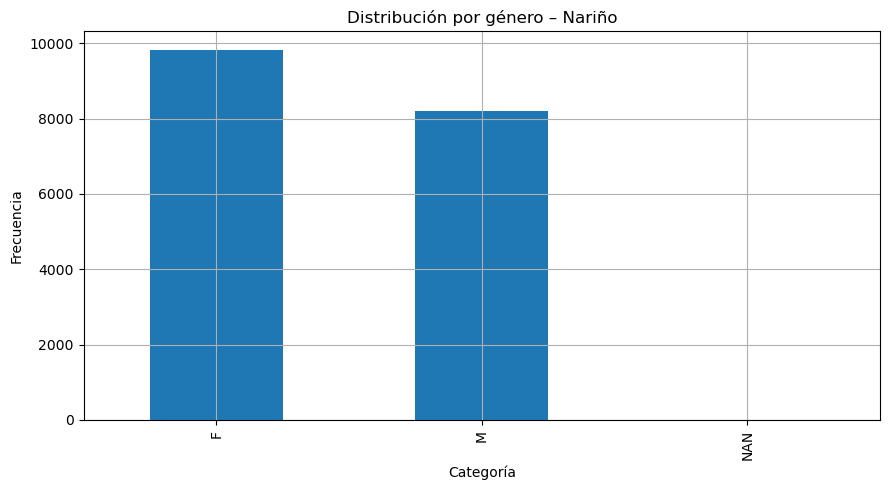

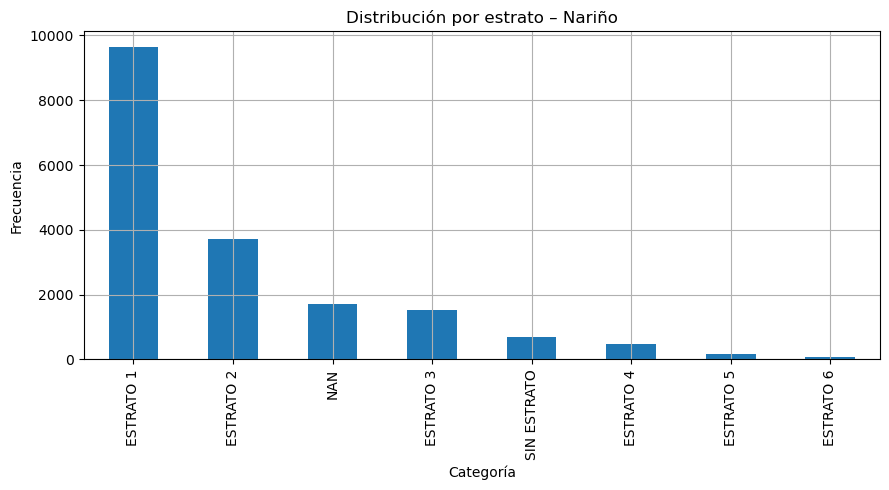

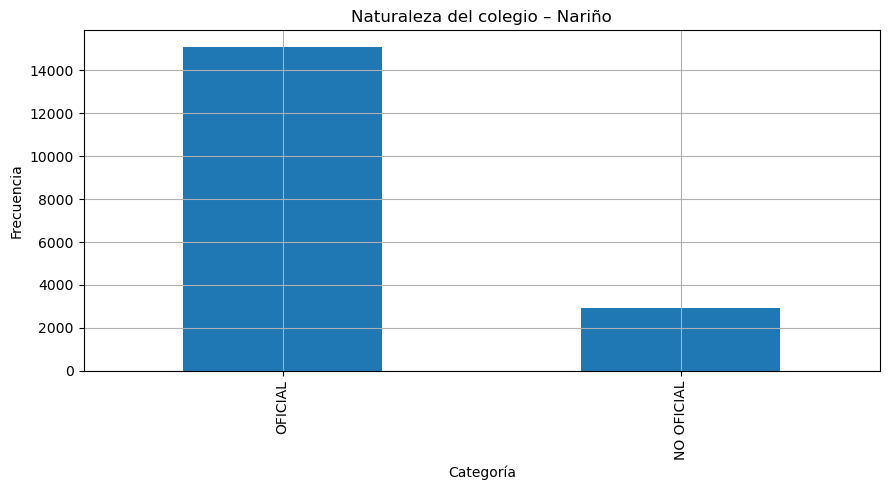

C:\Users\sebas\AppData\Local\Temp\ipykernel_12028\1283191449.py:8: UserWarning: Glyph 145 (\x91) missing from current font.
  plt.tight_layout()
c:\Users\sebas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


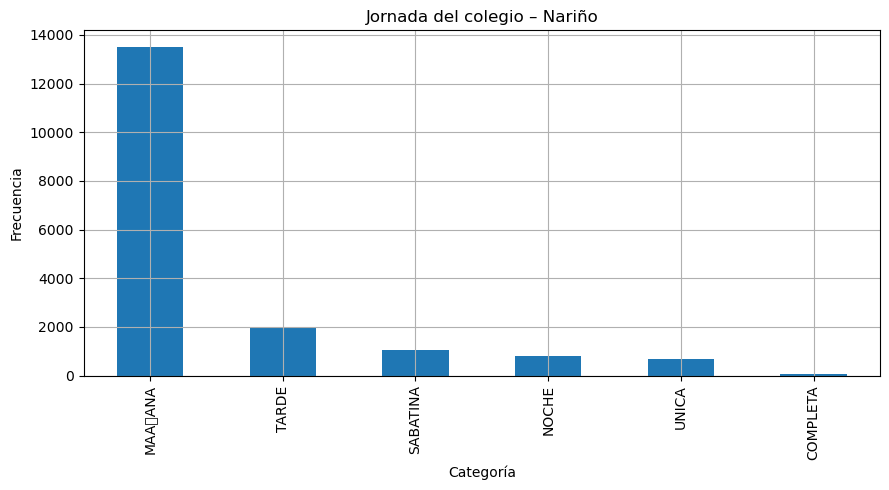

In [8]:

def bar_count(series, title):
    vc = series.value_counts(dropna=False)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Categoría")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

if "estu_genero" in df_narino.columns:
    bar_count(df_narino["estu_genero"], "Distribución por género – Nariño")

if "fami_estratovivienda" in df_narino.columns:
    bar_count(df_narino["fami_estratovivienda"], "Distribución por estrato – Nariño")

if "cole_naturaleza" in df_narino.columns:
    bar_count(df_narino["cole_naturaleza"], "Naturaleza del colegio – Nariño")

if "cole_jornada" in df_narino.columns:
    bar_count(df_narino["cole_jornada"], "Jornada del colegio – Nariño")

1. Distribución por género – Nariño

En 2018 se mantiene la tendencia de mayor participación femenina (cerca de 9.800) frente a la masculina (alrededor de 8.200). Esta diferencia, aunque no extrema, sigue siendo significativa para los modelos de Valor Agregado (VA) y Contribución Relativa (CR), pues confirma la predominancia de mujeres en la cohorte evaluada.

2. Distribución por estrato – Nariño

La concentración en el estrato 1 continúa siendo dominante, con más de 9.500 estudiantes, seguido del estrato 2 y proporciones menores en los estratos 3 y 4. La presencia marginal de estratos 5 y 6 reitera el contexto socioeconómico vulnerable del departamento, lo cual refuerza la necesidad de controlar esta variable en los análisis de impacto institucional.

3. Naturaleza del colegio – Nariño

La gran mayoría de estudiantes proviene de colegios oficiales, con una relación cercana a 5:1 respecto a los no oficiales. Esta característica refuerza la importancia del sistema educativo público como origen de los estudiantes que más adelante ingresarán a la educación superior, condicionando tanto el acceso a recursos como el desempeño de base.

4. Jornada del colegio – Nariño

La jornada de la mañana sigue siendo predominante, con una distribución muy superior frente a las demás jornadas (tarde, sabatina, nocturna, única o completa). La homogeneidad en este aspecto indica que la variable jornada tiene poco poder explicativo, pero continúa siendo útil para caracterizar la población.


**Uso en el TFM:** estas variables se incorporarán como **controles** al estimar el desempeño esperado en Saber Pro condicional a las características de entrada (baseline), permitiendo aislar el **efecto agregado** atribuible a la formación universitaria.



## 7) Distribución de puntajes (Nariño vs Pasto)

Las curvas y boxplots permiten visualizar **nivel y dispersión** de entrada por territorio.


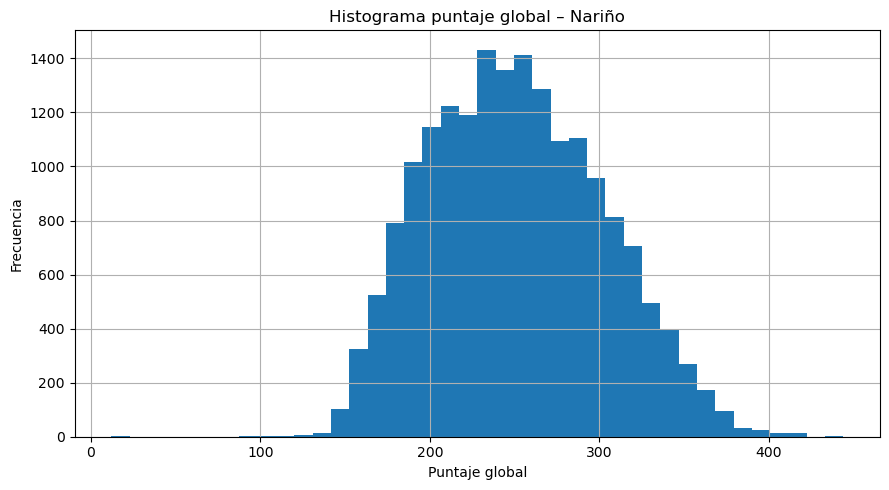

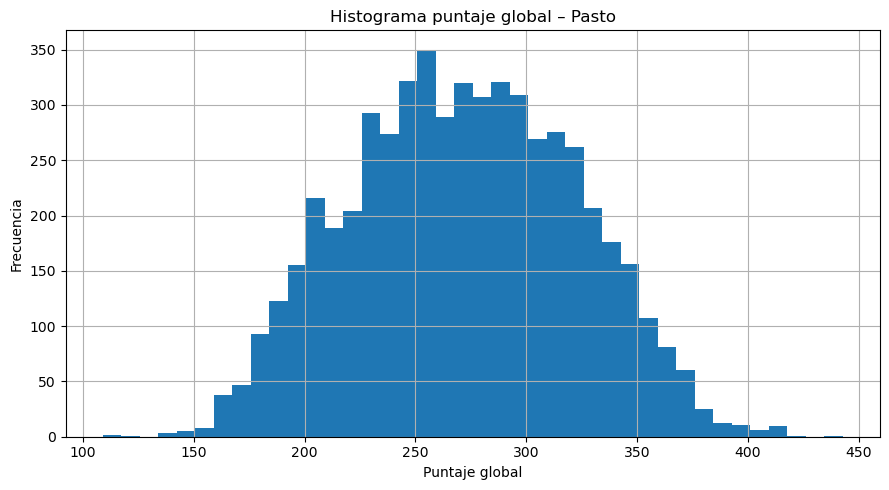

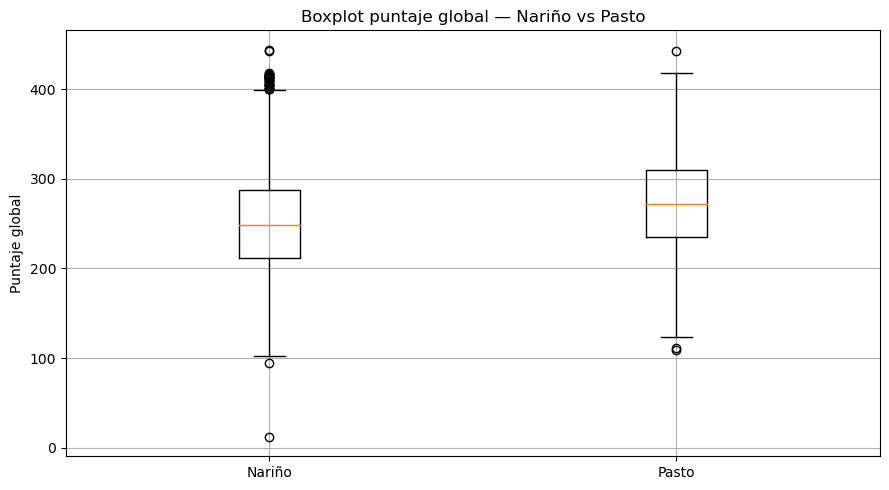

In [9]:

def hist_one(series, title, xlabel):
    if series.notna().any():
        plt.figure()
        series.dropna().plot(kind="hist", bins=40)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

# Hist global
hist_one(df_narino["punt_global"], "Histograma puntaje global – Nariño", "Puntaje global")
hist_one(df_pasto["punt_global"],  "Histograma puntaje global – Pasto",  "Puntaje global")

# Boxplot comparativo
vals, labels = [], []
if df_narino["punt_global"].notna().any():
    vals.append(df_narino["punt_global"].dropna()); labels.append("Nariño")
if df_pasto["punt_global"].notna().any():
    vals.append(df_pasto["punt_global"].dropna());  labels.append("Pasto")

if vals:
    plt.figure()
    plt.boxplot(vals, labels=labels, vert=True)
    plt.title("Boxplot puntaje global — Nariño vs Pasto")
    plt.ylabel("Puntaje global")
    plt.tight_layout()
    plt.show()

5. Histograma de puntaje global – Nariño

La distribución de los puntajes globales presenta nuevamente una forma aproximadamente normal, con un centro cercano a los 240–250 puntos. Esto confirma la tendencia a un rendimiento medio con dispersión moderada, constituyéndose en una base de comparación estable para los cálculos de VA.

6. Histograma de puntaje global – Pasto (2018)

En Pasto, la distribución de los puntajes globales se concentra principalmente entre 240 y 300 puntos, con una forma cercana a la normal. El promedio tiende a ubicarse ligeramente por encima del promedio departamental (≈260–270), lo cual confirma que los estudiantes de la capital parten de un nivel inicial más alto que el conjunto de Nariño.


7. Boxplot puntaje global — Nariño vs Pasto

El boxplot muestra que la mediana de Pasto es superior a la de Nariño, con un rango intercuartílico más compacto, lo que indica mayor homogeneidad en los puntajes de la capital frente a la dispersión departamental. Esta diferencia sigue siendo fundamental para ajustar los modelos de VA y CR, evitando sesgos derivados del contexto urbano.


**Uso en el TFM:** estas figuras justifican los **ajustes de baseline** por territorio (municipio) cuando se calcule VA/CR, y permiten reportar si Pasto difiere sistemáticamente del resto del departamento.



## 8) Comparación por áreas (medias)

Promedios por competencia para Nariño vs Pasto. Útil para identificar **áreas deficitarias** de entrada.


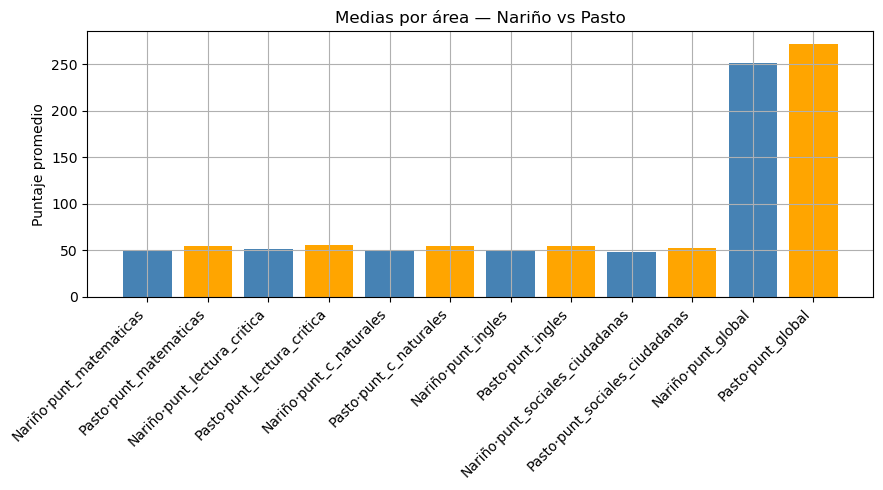

In [10]:
areas = ["punt_matematicas","punt_lectura_critica","punt_c_naturales",
         "punt_ingles","punt_sociales_ciudadanas","punt_global"]

means = []
labels = []
colors = []

for a in areas:
    if a in df_narino.columns:
        means.append(df_narino[a].mean())
        labels.append(f"Nariño·{a}")
        colors.append("steelblue")   # color para Nariño
    if a in df_pasto.columns:
        means.append(df_pasto[a].mean())
        labels.append(f"Pasto·{a}")
        colors.append("orange")      # color para Pasto

plt.figure()
plt.bar(labels, means, color=colors)
plt.title("Medias por área — Nariño vs Pasto")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Puntaje promedio")
plt.tight_layout()
plt.show()


7. Medias por área — Nariño vs Pasto

Los estudiantes de Pasto superan en promedio a los de Nariño en todas las áreas, especialmente en matemáticas y ciencias naturales, donde la diferencia es más marcada. Esta brecha anticipa que el impacto institucional puede ser más visible en dichas áreas si los programas de formación superior logran mejorar el desempeño de estudiantes que provienen de contextos con desventaja inicial.



**Uso en el TFM:** orienta hipótesis de **valor agregado diferencial por competencias** (p. ej., si el baseline en matemáticas es bajo, esperar mayor VA si la universidad fortalece esta área).



## 9) Ranking de colegios (Pasto)

Se listan los **Top-10** por puntaje global promedio.  
Esto sirve para construir *perfiles de ingreso* por colegio en la futura plataforma web.


In [14]:

ranking_pasto = pd.DataFrame()
if {"cole_nombre_establecimiento","punt_global"}.issubset(df_pasto.columns):
    ranking_pasto = (df_pasto
                     .groupby("cole_nombre_establecimiento", as_index=False)["punt_global"]
                     .mean()
                     .sort_values("punt_global", ascending=False)
                     .head(10))
    display(ranking_pasto)
else:
    print("No hay columnas suficientes para el ranking.")

,cole_nombre_establecimiento,punt_global
67,LIC INTEGD DE BTO UNIVERSIDAD DE NARIAO,349.785714
14,COL SAN FRANCISCO JAVIER,342.915663
17,COLEGIO DEL SAGRADO CORAZON DE JESUS,329.325000
69,LICEO DE LA MERCED MARIDIAZ,319.509434
58,INST CHAMPAGNAT,317.863014
3,COL COMFAMILIAR DE NARIAO SIGLO XXI,312.238806
5,COL FILIPENSE NUESTRA SRA DE LA ESPERANZA,307.700000
7,COL LA INMACULADA,306.442857
13,COL SAN FELIPE NERI,301.136000
48,I.E.M. NORMAL SUPERIOR DE PASTO,298.072340



## 10) Exportación — **Features de entrada** para VA/CR

Se exportan datasets **limpios** y agregados que el pipeline utilizará al cruzar con Saber Pro:
- `s11_2016_narino.csv`, `s11_2016_pasto.csv` → registros individuales filtrados.
- `s11_2016_school_summary.csv` → promedio y tamaño por colegio (Nariño/Pasto).
- `s11_2016_muni_summary.csv` → promedio por municipio (Nariño).


In [15]:
from pathlib import Path
import pandas as pd

# Usa una ruta corta/sencilla (cámbiala si quieres)
out_dir = Path(r"C:\Temp\s11_2017_tfm_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]

muni_summary = df_narino

out_file = out_dir / "s11_2018_muni_summary.csv"
muni_summary.to_csv(str(out_file), index=False, encoding="utf-8-sig")  # <-- str(...)
print("✅ Guardado:", out_file)


✅ Guardado: C:\Temp\s11_2017_tfm_outputs\s11_2018_muni_summary.csv


Síntesis global del año 2018

Sociodemografía estable: mayoría de mujeres, estrato 1 y colegios oficiales.

Académico: puntaje global con media alrededor de 240–250 puntos, con ligera mejora en Pasto.

Implicación para VA/CR: el análisis reafirma la necesidad de considerar el contexto socioeconómico y urbano-rural como variables de control, dado que las diferencias de base pueden influir en el cálculo del valor agregado.